# Classification of the sarcastic news

## Introduction

A binary classification model is created to detect the sarcastic news based on the head lines of the news using NLP and Tensorflow. The dataset for this project is taken from Kaggle.

## Outline

1. Overview of the data
2. Train and Test split
3. Encoding
4. Model Building
5. Word Embeddings

# Overview of the data


In [7]:
# the dataset
import json

with open('Sarcasm_Headlines_Dataset.json', 'r') as f:
    df = json.load(f)

print(f'A sample in the data looks like:\n \n {df[0]}')
print(f'\nThere are total {len(df)} headlines')

A sample in the data looks like:
 
 {'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}

There are total 26709 headlines


In [8]:
# Separating headlines and lables
headline, urls, label = [], [], []

for item in df:
    headline.append(item['headline'])
    urls.append(item['article_link'])
    label.append(item['is_sarcastic'])

# Train and Test Split

In [17]:
import numpy as np
train_size = 20000
# training set
head_tr = headline[0:train_size]
label_tr = np.array(label[0:train_size])
# testing set
head_te = headline[train_size:]
label_te = np.array(label[train_size:])

# Encodation

In [63]:
# hyperParameters

vsize = 10000 # maximum unique words
nwords = 40 # maximum words in one headline
embed_dim = 16 # embedded vector dimension
trunc = 'post'

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer

# initialization
encoder = Tokenizer(num_words=vsize, oov_token='')

# encoding 
encoder.fit_on_texts(head_tr)
word_index = encoder.word_index

print(f"there are total {len(word_index)-1} unique words are present in training set")

there are total 25636 unique words are present in training set


In [65]:
# sequence creation
seq_tr = encoder.texts_to_sequences(head_tr)
seq_te = encoder.texts_to_sequences(head_te)

# padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
pad_tr = pad_sequences(seq_tr, maxlen=nwords, truncating=trunc)
pad_te = pad_sequences(seq_te, maxlen=nwords, truncating=trunc)

# Model Building

In [66]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vsize, embed_dim, input_length = nwords),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 16)            160000    
                                                                 
 global_average_pooling1d_9   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Model training

model_history = model.fit(pad_tr, label_tr, epochs=30, validation_data=(pad_te, label_te), verbose = 0)
print(f"Accuracy at epochs 30: \naccuracy = {model_history.history['accuracy'][-1]} \nvalidation_accuracy = {model_history.history['val_accuracy'][-1]}")

Accuracy at epochs 30: 
accuracy = 0.9805499911308289 
validation_accuracy = 0.8341034650802612


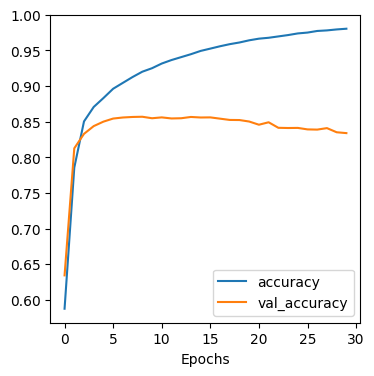

In [68]:
# accuracy plots
plt.rcParams['figure.figsize'] = [4, 4]
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Model Testing

In [72]:
head_te[68]

'un: israeli freeze on palestinian permits after attack may be collective punishment'

In [73]:
def getSarcasmProb(headline):
    seq = encoder.texts_to_sequences([headline])
    pad = pad_sequences(seq, maxlen=nwords, truncating=trunc)
    result = model.predict(pad, verbose = 0)
    print('Sarcasm score between 0 and 1 (closer to 0- non-sarcastic):\n')
    return(result[0][0])

In [74]:
headline = 'un: israeli freeze on palestinian permits after attack may be collective punishment'
getSarcasmProb(headline)

Sarcasm score between 0 and 1 (closer to 0- non-sarcastic):



0.010270123

# Word Embeddings

In [77]:
# model weights

reverse_word_index = encoder.index_word
embedding_layers = model.layers[0]
embedding_weights = embedding_layers.get_weights()[0]

# Files for embbeding projector
import io
vectors = io.open('vectors.tsv', 'w', encoding='utf-8')
words = io.open('vectors.tsv', 'w', encoding='utf-8')

for i in range(1, vsize):
    word = reverse_word_index[i]
    word_emb = embedding_weights[i]
    words.write(word+"\n")
    vectors.write('\t'.join([str(x) for x in word_emb]) + "\n")
vectors.close()
words.close()